# Analyze E8 for DELL


Known VCPs for my DELL U4323QE:

- 60 (standard) primary source
- E7 (custom) KVM Switch Display to USB port assignment
  - write `xff00` to switch to the next screen next [^1]
- E8 (custom) secondary sources
- E9 (custom) PBP/PIP mode

The code below is meant to analyze E8. I think E9 is just enumerated, no idea if there's a rule. 60 is very easy to get manually - there are only 5 possibilities.

| Input | VCP 60 |
| ----- | ------ |
| USBC  | 0x1b   |
| HDMI1 | 0x11   |
| HDMI2 | 0x12   |
| DP1   | 0x0f   |
| DP2   | 0x13   |


| PxP mode                        | VCP E9  | (dec) |
| ------------------------------- | ------- | ----- |
| PIP with small window[^2]       | x00 x21 | 33    |
| PBP two horizontal windows      | x00 x2f | 47    |
| PBP two vertical windows        | x00 x24 | 36    |
| PBP two by two                  | x00 x41 | 65    |
| PBP wide top, two on the bottom | x00 x?? | 51    |
| PBP/PIP off                     | 0x0     | 0     |

[^1]: https://github.com/rockowitz/ddcutil/issues/192
[^2]: doesn't control the position of the small window


## Windows ordering

### 2x2 `65`

| Window 1 | >>       |
| -------- | -------- |
| Window 3 | Window 2 |

### 1 plus 2 `51`

| Window 1 | >>       |
| -------- | -------- |
| Window 3 | Window 2 |

### 3 vertically `52`

| Window 1 |
| -------- |
| Window 2 |
| Window 3 |


# Results


In [3]:
from enum import IntEnum


class VCP(IntEnum):
    INPUT = 0x60
    KVM = 0xE7
    PBP_INPUT = 0xE8
    PBP_MODE = 0xE9


KVM_NEXT_INPUT = 0xFF00


class KvmUSBIdx(IntEnum):
    USB1 = 1
    USB2 = 2
    USB3 = 3
    USB4 = 4


class Input(IntEnum):
    HDMI1 = 0x11  # 17
    HDMI2 = 0x12  # 18
    DP1 = 0x0F  # 15
    DP2 = 0x13  # 19
    USBC = 0x1B  # 27


In [4]:
def model_kvm_inputs(
    DP1: KvmUSBIdx,
    DP2: KvmUSBIdx,
    HDMI1: KvmUSBIdx,
    HDMI2: KvmUSBIdx,
) -> int:
    return (
        0
        + DP1 * (2 << 11)
        - DP2 * (2 << 8)
        - HDMI1 * (2 << 8)
        - ((HDMI2 - 1) * (-2 << 5))
    )


def model_kvm_inputs_by_names(
    DP1: str,
    DP2: str,
    HDMI1: str,
    HDMI2: str,
) -> int:
    return model_kvm_inputs(
        DP1=KvmUSBIdx[DP1],
        DP2=KvmUSBIdx[DP2],
        HDMI1=KvmUSBIdx[HDMI1],
        HDMI2=KvmUSBIdx[HDMI2],
    )


def model_pbp_order(S2: Input, S3: Input, S4: Input) -> int:
    return (S2 << 0) ^ (S3 << 5) ^ (S4 << 10)


def model_pbp_order_by_names(S2: str, S3: str, S4: str) -> int:
    return model_pbp_order(
        S2=Input[S2],
        S3=Input[S3],
        S4=Input[S4],
    )


In [6]:
import pandas as pd
from itertools import product


windows = set(product([s.name for s in Input], repeat=4))
windows = list(filter(lambda ws: len(set(ws)) == len(ws), windows))


df = pd.DataFrame(windows, columns=["Window 1", "Window 2", "Window 3", "Window 4"])
df["VCP E8"] = df.apply(
    lambda row: hex(model_pbp_order_by_names(*row.values[1:4])), axis=1
)
df["VCP E8 (dec)"] = df.apply(lambda row: int(row["VCP E8"], base=16), axis=1)
df["VCP 60"] = df.apply(lambda row: hex(Input[row["Window 1"]]), axis=1)
df["VCP 60 (dec)"] = df.apply(lambda row: int(row["VCP 60"], base=16), axis=1)
df.sort_values(
    ["Window 1", "Window 2", "Window 3", "Window 4"], inplace=True, ignore_index=True
)
df

filtered_df = df[
    (df["Window 1"] == "USBC")
    & (df["Window 2"] == "HDMI2")
    & (df["Window 3"] == "DP2")
    & (df["Window 4"] == "DP1")
]
filtered_df


,Window 1,Window 2,Window 3,Window 4,VCP E8,VCP E8 (dec),VCP 60,VCP 60 (dec)
116,USBC,HDMI2,DP2,DP1,0x3e72,15986,0x1b,27


In [266]:
import pandas as pd
from itertools import product


windows = set(product([s.name for s in KvmUSBIdx], repeat=4))
windows = list(filter(lambda ws: len(set(ws)) == len(ws), windows))


df = pd.DataFrame(windows, columns=["DP1", "DP2", "HDMI1", "HDMI2"])
df["VCP E7"] = df.apply(
    lambda row: hex(model_kvm_inputs_by_names(*row.values[0:4])), axis=1
)
df["VCP E7 (dec)"] = df.apply(lambda row: int(row["VCP E7"], base=16), axis=1)
df.sort_values(
    ["DP1", "DP2", "HDMI1", "HDMI2"], inplace=True, ignore_index=True
)
df

filtered_df = df[
    (df["DP1"] == "USB3")
    # & (df["DP2"] == "USB2")
    & (df["HDMI1"] == "USB2")
    & (df["HDMI2"] == "USB4")
]
filtered_df


,DP1,DP2,HDMI1,HDMI2,VCP E7,VCP E7 (dec)
12,USB3,USB1,USB2,USB4,0x2ac0,10944


# DATA

## E7


In [10]:
import pandas as pd
import numpy as np
from typing import NamedTuple


class KvmState(NamedTuple):
    # The order in OSD is DP1, DP2, HDMI1, HDMI2
    # The USBs are numbered from one (same as the Display Input USBC) to 4
    # Unsure what assigning one means, probably same as off?
    DP1: int
    DP2: int
    HDMI1: int
    HDMI2: int
    VCPE7: int


data: list[KvmState] = [
    (4, 2, 3, 3, 0x3680),
    (4, 2, 3, 4, 0x36C0),
    (4, 2, 3, 2, 0x3640),
    (4, 2, 3, 1, 0x3600),
    (1, 2, 3, 1, 0x0600),
    (2, 2, 3, 1, 0x1600),
    (3, 2, 3, 1, 0x2600),
    (4, 2, 3, 1, 0x3600),
]

df = pd.DataFrame(data, columns=["S1", "S2", "S3", "S4", "Output"])

## E8

In [3]:
import pandas as pd
import numpy as np

NONE = None
HDMI1 = Input.HDMI1
HDMI2 = Input.HDMI2
DP1 = Input.DP1
DP2 = Input.DP2
USBC = Input.USBC

data = [
    (DP2, DP1, DP1, DP1, 0x3DEF),
    (DP2, HDMI1, DP1, DP1, 0x3DF1),
    (DP2, HDMI2, DP1, DP1, 0x3DF2),
    #  (DP2, HDMI2, NONE, NONE, 0x3DF2),
    (DP2, DP2, DP1, DP1, 0x3DF3),
    # (DP2, DP2, NONE, NONE, 0x3DF3),
    # (HDMI1, DP2, NONE, NONE, 0x3DF3),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (DP2, USBC, DP1, DP1, 0x3DFB),
    (HDMI1, HDMI2, DP2, DP1, 0x3E72),
    (HDMI1, DP2, DP2, DP1, 0x3E73),
    (HDMI1, HDMI2, USBC, DP1, 0x3F72),
    # (HDMI1, DP2, NONE, NONE, 0x3F73),
    (DP2, DP2, USBC, DP1, 0x3F73),
    # (DP2, NONE, NONE, NONE, 0x3F73),
    # (DP2, DP2, NONE, NONE, 0x3F73),
    (HDMI1, USBC, USBC, DP1, 0x3F7B),
    (DP2, USBC, DP1, HDMI1, 0x45FB),
    (DP2, HDMI1, DP1, HDMI2, 0x49F1),
    (DP2, HDMI2, DP1, HDMI2, 0x49F2),
    (DP2, USBC, DP1, HDMI2, 0x49FB),
    (DP2, HDMI1, HDMI1, HDMI2, 0x4A31),
    (DP2, HDMI1, DP2, HDMI2, 0x4A71),
    (DP2, USBC, DP1, DP2, 0x4DFB),
    (DP2, USBC, DP1, USBC, 0x6DFB),
    (HDMI1, DP2, DP2, USBC, 0x6E73),
]

# Tworzymy DataFrame dla lepszej analizy
df = pd.DataFrame(data, columns=["S1", "S2", "S3", "S4", "Output"])

# Training

In [17]:
from sklearn.model_selection import train_test_split

# 2. Podział danych na cechy (X) i etykiety (y)
feature_names = ["S1", "S2", "S3", "S4"]
X = df[feature_names]  # Stany wejściowe
y = df["Output"]  # Wyjście (2 bajty)

# 3. Podział danych na zbór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
X_train

,S1,S2,S3,S4
0,4,2,3,3
7,4,2,3,1
2,4,2,3,2
4,1,2,3,1
3,4,2,3,1
6,3,2,3,1


## HistGradientBoostingRegressor


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

# 4. Dopasowanie modelu
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

perm_importance = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42
)

In [ ]:
print("Ważność cech (permutation importance):")
for feature, importance in zip(X.columns, perm_importance.importances_mean):
    print(f"{feature}: {importance:.4f}")


# Tworzenie funkcji predykcyjnej
def predict_output_hist(S1, S2, S3, S4):
    """
    Funkcja predykcyjna dla modelu HistGradientBoostingRegressor.
    :param S1: Wartość stanu S1
    :param S2: Wartość stanu S2
    :param S3: Wartość stanu S3
    :param S4: Wartość stanu S4
    :return: Przewidywane wyjście
    """
    input_data = np.array([[S2, S3, S4]])
    output = model.predict(input_data)
    return int(output[0])  # Konwersja wyniku na liczbę całkowitą


# Testowanie funkcji
example_output = predict_output_hist(0, 0, 1, 0)
print(f"Przewidywane wyjście funkcji predict_output_hist: {hex(example_output)}")

## DecisionTreeClassifier


In [ ]:
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier


#  4. Dopasowanie modelu
# Wykorzystujemy Random Forest do analizy zależności (można zmienić na inny model)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
# 6. Analiza wyników
# Sprawdzamy jakość predykcji (dla uproszczenia rzutujemy wyjścia na int)
accuracy = (np.round(predictions) == y_test).mean()
print(f"Dokładność modelu: {accuracy * 100:.2f}%")

# 7. Analiza znaczenia cech
# Ważności cech (pokazuje, które stany mają największy wpływ na wyjście)
feature_importances = model.feature_importances_
for i, col in enumerate(X.columns):
    print(f"Znaczenie {col}: {feature_importances[i]:.4f}")

exported = export_text(model, feature_names=feature_names)
print(exported)

## RandomForestRegressor


In [147]:
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor


#  4. Dopasowanie modelu
# Wykorzystujemy Random Forest do analizy zależności (można zmienić na inny model)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
from sklearn.tree import export_text, plot_tree

print("Ważność cech w RandomForestRegressor:")
for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Eksportowanie jednego z drzew
single_tree = model.estimators_[0]  # Pierwsze drzewo
print("Reguły pierwszego drzewa:")
print(export_text(single_tree, feature_names=X.columns.tolist()))

In [ ]:
# Wizualizacja drzewa
plt.figure(figsize=(15, 10))
plot_tree(single_tree, feature_names=X.columns, filled=True)
plt.title("Wizualizacja pierwszego drzewa w RandomForestRegressor")
plt.show()

## CategoricalNB


In [ ]:
from sklearn.naive_bayes import CategoricalNB

#  4. Dopasowanie modelu
model = CategoricalNB()
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
# Priorytety klas
# print("Priorytety klas (class_prior_):")
# for cls, prior in zip(model.classes_, model.class_prior_):
#     print(f"Klasa {cls}: {prior:.4f}")

# Prawdopodobieństwa warunkowe
print("Prawdopodobieństwa warunkowe (logarytmy):")
for class_idx, class_probs in enumerate(model.feature_log_prob_):
    print(f"  Klasa {model.classes_[class_idx]}:")
    for feature, log_prob in zip(X.columns, class_probs):
        print(log_prob)
        print(
            f"    {feature}: {np.exp(float(log_prob.item)):.4f}"
        )  # Konwersja na float

## LinearRegression


In [152]:
from sklearn.linear_model import LinearRegression

#  4. Dopasowanie modelu
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predykcja
# Sprawdzamy, jak dobrze model przewiduje wyjście
predictions = model.predict(X_test)

In [ ]:
from math import log2

print("Wagi regresji liniowej:")
for feature, coef in zip(X.columns, model.coef_):
    c = log2(abs(int(coef)))
    print(f"{feature}: {c:.4f}")

In [ ]:
2 << 10

## Manual approach


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



In [40]:
# 4. Funkcja generująca funkcję predykcyjną na podstawie wag (E8)
# (0, 5, 10, 0)
def generate_function(w6=0, w7=5, w8=10):
    def model(S2, S3, S4):
        source_values = {
            HDMI1: 0x11,
            HDMI2: 0x12,
            DP1: 0x0F,
            DP2: 0x13,
            USBC: 0x1B,
        }
        a = source_values[S2] << int(abs(w6))
        b = source_values[S3] << int(abs(w7))
        c = source_values[S4] << int(abs(w8))
        return  a ^ b ^ c

    return model


In [168]:
# 4. Funkcja generująca funkcję predykcyjną na podstawie wag (E7, KVM)
def generate_function(w1=11, w2=8, w3=8, w4=5):
    def model(DP1, DP2, HDMI1, HDMI2):
        return (
            0
            + DP1 * (2 << w1)
            - DP2 * (2 << w2)
            - HDMI1 * (2 << w3)
            - ((HDMI2 - 1) * (-2 << w4))
        )

    return model


In [171]:
from scipy.optimize import minimize
from itertools import product
from typing import Callable
from sklearn.metrics import mean_absolute_error


def grid_search_integer_weights(
    X,
    y,
    model_generator: Callable,
    n_weights=3,
    min_weight=2,
    max_weight=16,
):
    best_mae = float("inf")
    best_weights = None
    for weights in product(range(min_weight, max_weight + 1), repeat=n_weights):
        model = model_generator(*weights)
        predictions = np.array([model(*row) for row in X.values])
        mae = mean_absolute_error(y, predictions)
        if mae < best_mae:
            best_mae = mae
            best_weights = weights
    return best_weights, best_mae


def optimize_weights_continous(
    X,
    y,
    model_generator: Callable,
    n_weights: int = 3,
    start_weight: float = 1.0,
    method="BFGS",
):
    def objective_function(weights, X, y):
        model = model_generator(*weights)
        predictions = np.array([model(*row) for row in X.values])
        return mean_absolute_error(y, predictions)

    # 6. Optymalizacja wag
    initial_weights = [float(start_weight)] * n_weights
    result = minimize(objective_function, initial_weights, args=(X, y), method=method)
    optimized_weights = result.x

    optimized_model = generate_function(*optimized_weights)
    predicted_outputs = np.array([optimized_model(*row) for row in X.values])
    mae = mean_absolute_error(y, predicted_outputs)

    return optimized_weights, mae


# optimizer = optimize_weights_continous
optimizer = grid_search_integer_weights

optimized_weights, best_mae = grid_search_integer_weights(
    X_train,
    y_train,
    generate_function,
    n_weights=4,
    min_weight=5,
    max_weight=12,
)
print(f"Średni błąd absolutny (int): {best_mae:.4f}")
print("Optymalizowane wagi:", optimized_weights)

Średni błąd absolutny (int): 0.0000
Optymalizowane wagi: (11, 8, 8, 5)


Średni błąd absolutny dla optymalizowanych wag: 0.0000
Średni błąd absolutny dla optymalizowanych wag (całość): 0.0000


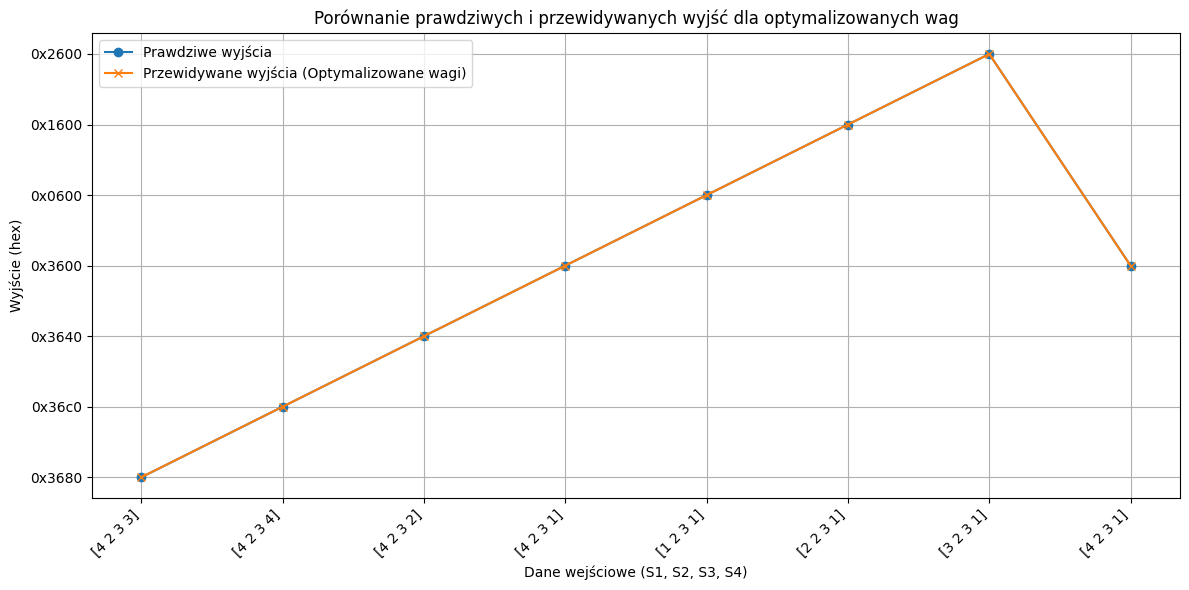

In [172]:
optimized_weights = (11, 8, 8, 5)
# 7. Test with new weights
optimized_model = generate_function(*optimized_weights)
predicted_outputs = np.array([optimized_model(*row) for row in X_test.values])
mae = mean_absolute_error(y_test, predicted_outputs)
print(f"Średni błąd absolutny dla optymalizowanych wag: {mae:.4f}")

# 8.1 Generate model
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = np.array([optimized_model(*row) for row in all_inputs])
print(f"Średni błąd absolutny dla optymalizowanych wag (całość): {mae:.4f}")


# 8.2 Plot
x_labels = [f"{row}" for row in X.values]
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y)),
    [f"{int(val):#06x}" for val in y.values],
    label="Prawdziwe wyjścia",
    marker="o",
)
plt.plot(
    range(len(all_predicted_outputs)),
    [f"{int(val):#06x}" for val in all_predicted_outputs],
    label="Przewidywane wyjścia (Optymalizowane wagi)",
    marker="x",
)
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha="right")
plt.title("Porównanie prawdziwych i przewidywanych wyjść dla optymalizowanych wag")
plt.xlabel("Dane wejściowe (S1, S2, S3, S4)")
plt.ylabel("Wyjście (hex)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [173]:
combined_df = pd.DataFrame(
    {
        "S1": X.values[:, 0],
        "S2": X.values[:, 1],
        "S3": X.values[:, 2],
        "S4": X.values[:, 3],
        "Prawdziwe wyjścia": y.values,
        "Przewidywane wyjścia": all_predicted_outputs,
        "Error": all_predicted_outputs - y.values,
        "A": (
            0
            + X.values[:, 0] * (2 << 11)
            - X.values[:, 1] * (2 << 8)
            - X.values[:, 2] * (2 << 8)
            - ((X.values[:, 3] - 1) * (-2 << 5))
        )
        - y.values,
    }
)

combined_df

,S1,S2,S3,S4,Prawdziwe wyjścia,Przewidywane wyjścia,Error,A
0,4,2,3,3,13952,13952,0,0
1,4,2,3,4,14016,14016,0,0
2,4,2,3,2,13888,13888,0,0
3,4,2,3,1,13824,13824,0,0
4,1,2,3,1,1536,1536,0,0
5,2,2,3,1,5632,5632,0,0
6,3,2,3,1,9728,9728,0,0
7,4,2,3,1,13824,13824,0,0


In [135]:
-2 << 5

-64

## Visuals


In [ ]:
# 9. Opcjonalne: Wizualizacja wyników
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions, alpha=0.6)
plt.xlabel("Rzeczywiste wyjścia")
plt.ylabel("Przewidywane wyjścia")
plt.title("Porównanie rzeczywistych i przewidywanych wyjść")
plt.show()

In [ ]:
# 8. Eksport wyników i interpretacja
# Wyniki mogą zostać zapisane do pliku CSV dla dalszej analizy
df_results = pd.DataFrame({"Actual": y_test, "Predicted": np.round(predictions)})
df_results
# df_results.to_csv("results.csv", index=False)

# Attempt at model choice


In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# 4. Funkcja do porównywania modeli
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
        "RandomForestRegressor": RandomForestRegressor(random_state=42),
        "CategoricalNB": CategoricalNB(),
        "HistGradientBoostingRegressor": HistGradientBoostingRegressor(random_state=42),
    }

    results = {}

    for name, model in models.items():
        try:
            # Dopasowanie modelu
            model.fit(X_train, y_train)
            # Predykcja
            predictions = model.predict(X_test)
            # Ocena
            mae = mean_absolute_error(y_test, predictions)
            results[name] = mae
        except Exception as e:
            results[name] = f"Error: {e}"

    return results


# 5. Porównanie modeli
results = compare_models(X_train, X_test, y_train, y_test)
for model_name, score in results.items():
    print(f"{model_name}: {score}")

# Test output function


In [ ]:
# 7. Tworzenie funkcji predykcyjnej
def predict_output_model(S2, S3, S4):
    input_data = np.array([[S2, S3, S4]])
    output = model.predict(input_data)
    return int(output[0])  # Konwersja wyniku na liczbę całkowitą


predict_output = predict_output_model

# 8. Testowanie funkcji generującej na wszystkich inputach i wizualizacja
all_inputs = X.values
all_true_outputs = y.values
all_predicted_outputs = [predict_output(*row) for row in all_inputs]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(all_true_outputs, label="Prawdziwe wyjścia", marker="o")
plt.plot(all_predicted_outputs, label="Przewidywane wyjścia", marker="x")
plt.title("Porównanie prawdziwych i przewidywanych wyjść")
plt.xlabel("Przykład")
plt.ylabel("Wyjście")
plt.legend()
plt.grid()
plt.show()